# Optimization

### Collect training features

In [6]:
import numpy as np
import random
import os, sys
import matplotlib.pyplot as plt
import warnings
from lib.esn import ESN
from dataset.loading import Feature_Collector

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

path = '../../data/'
fc = Feature_Collector(path)

dr = []
speakers = []
XorZ = "Z"
long_version = False
n_mels = 13
delta = False
delta_delta = False
subsamples = 10
const_params = {
    "n_mels":n_mels,
    "XorZ":XorZ
}

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features_train, labels_train, _ = fc.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


### Regroup data and subset phonemes

In [7]:
from dataset.data_helpers import *

phonemes, features_train, labels_train = filter_data(features_train, labels_train, limit=None)

Filtered to 177080 samples of shape (10, 13)


### Compute conceptors

In [8]:
from lib.experiment_helpers import *
from sklearn.base import BaseEstimator, ClassifierMixin

class Classifier(BaseEstimator, ClassifierMixin):

    def __init__(self,
                 W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights):
        self.W_in_scale = W_in_scale
        self.spectral_radius = spectral_radius
        self.b_scale = b_scale
        self.weights = weights

    def fit(self, X, y, **params):
        self.n_mels = params["n_mels"]
        self.XorZ = params["XorZ"]

        # Group data by class
        group = group_by_labels(X, y)

        self.classes = list(group.keys())
        self.n_samples = sum([len(x) for x in list(group.values())])

        print(f"Number of samples: {self.n_samples}")
        # Init Reservoir
        esn_params = {
            "in_dim": self.n_mels,
            "out_dim": self.n_mels,
            "N": 4 + 6 * (self.XorZ == "X"),
            "W_in_scale": self.W_in_scale,
            "b_scale": self.b_scale,
            "spectral_radius": self.spectral_radius,
            "weights": self.weights
        }
        self.esn = ESN(esn_params)
        self.Cs_clas, self.Ns_clas = compute_Cs_and_Ns(group, esn=self.esn, aperture="auto", normalize=True, XorZ=self.XorZ, cache=False)

        # Return the classifier
        return self

    def predict(self, X):
        y = []
        for sample in X:
            x = self.esn.run(sample.T, XorZ=self.XorZ)
            es = evidences_for_Cs(x,self.Cs_clas,self.Ns_clas)
            if self.XorZ == "X":
                es = [ np.sum(p) for p in es ]
            y.append(self.classes[np.argmax(es)])

        return y

In [4]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train,
                                        stratify = labels_train,
                                        random_state = 1)


# Bayesian Optimization wrapper
def objective_function(W_in_scale,
                       b_scale,
                       spectral_radius,
                       weights):
    model = Classifier(W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights)
    model.fit(X_train, y_train, **const_params)
    return model.score(X_test, y_test)


parameters = {
    'W_in_scale': [.01, 2],
    'spectral_radius': [0.01, 4],
    'b_scale': [0, 2],
    'weights': [.01,1]
}

# Bayesian optimization of the objective function.
optimizer = BayesianOptimization(f = objective_function,
                                 pbounds = parameters,
                                 random_state = 1)
optimizer.maximize(init_points = 10, n_iter = 50)

best_params = optimizer.max['params']
print(f"Best parmaters: {best_params}; f(x) = {optimizer.max['target']}.")

|   iter    |  target   | W_in_s... |  b_scale  | spectr... |  weights  |
-------------------------------------------------------------------------
Number of samples: 292
- computing conceptors
optimizing
Computing gammas...


KeyboardInterrupt: 

<Figure size 360x360 with 0 Axes>

# Plotting Progress

In [ ]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize = (15, 5))

# Scores:
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, label="Accuracy - $f(\\rho$, $k_{W^in}$, $k_b$, $r$)")

# Parameters
W_in_scale = []
b_scale = []
spectral_radius = []
weights = []

for res in optimizer.res:
    W_in_scale.append(res["params"]["W_in_scale"])
    b_scale.append(res["params"]["b_scale"])
    spectral_radius.append(res["params"]["spectral_radius"])
    weights.append(res["params"]["weights"])

if False:
    plt.plot(range(1, 1 + len(optimizer.space.target)), W_in_scale, "--", label="$W^in$")
    plt.plot(range(1, 1 + len(optimizer.space.target)), b_scale, "--", label="$k_b$")
    plt.plot(range(1, 1 + len(optimizer.space.target)), spectral_radius, "--", label="$r$")
    plt.plot(range(1, 1 + len(optimizer.space.target)), weights, "--", label="$\\rho$")

plt.grid(True)
plt.xlabel("Iteration", fontsize = 20)
plt.legend(loc="upper left", fontsize = 20)
plt.show()

## Classification

Number of samples: 177080
- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  63.34303831151579
normalizing
Target:  7.373755031649612
std 0.32811292459167296


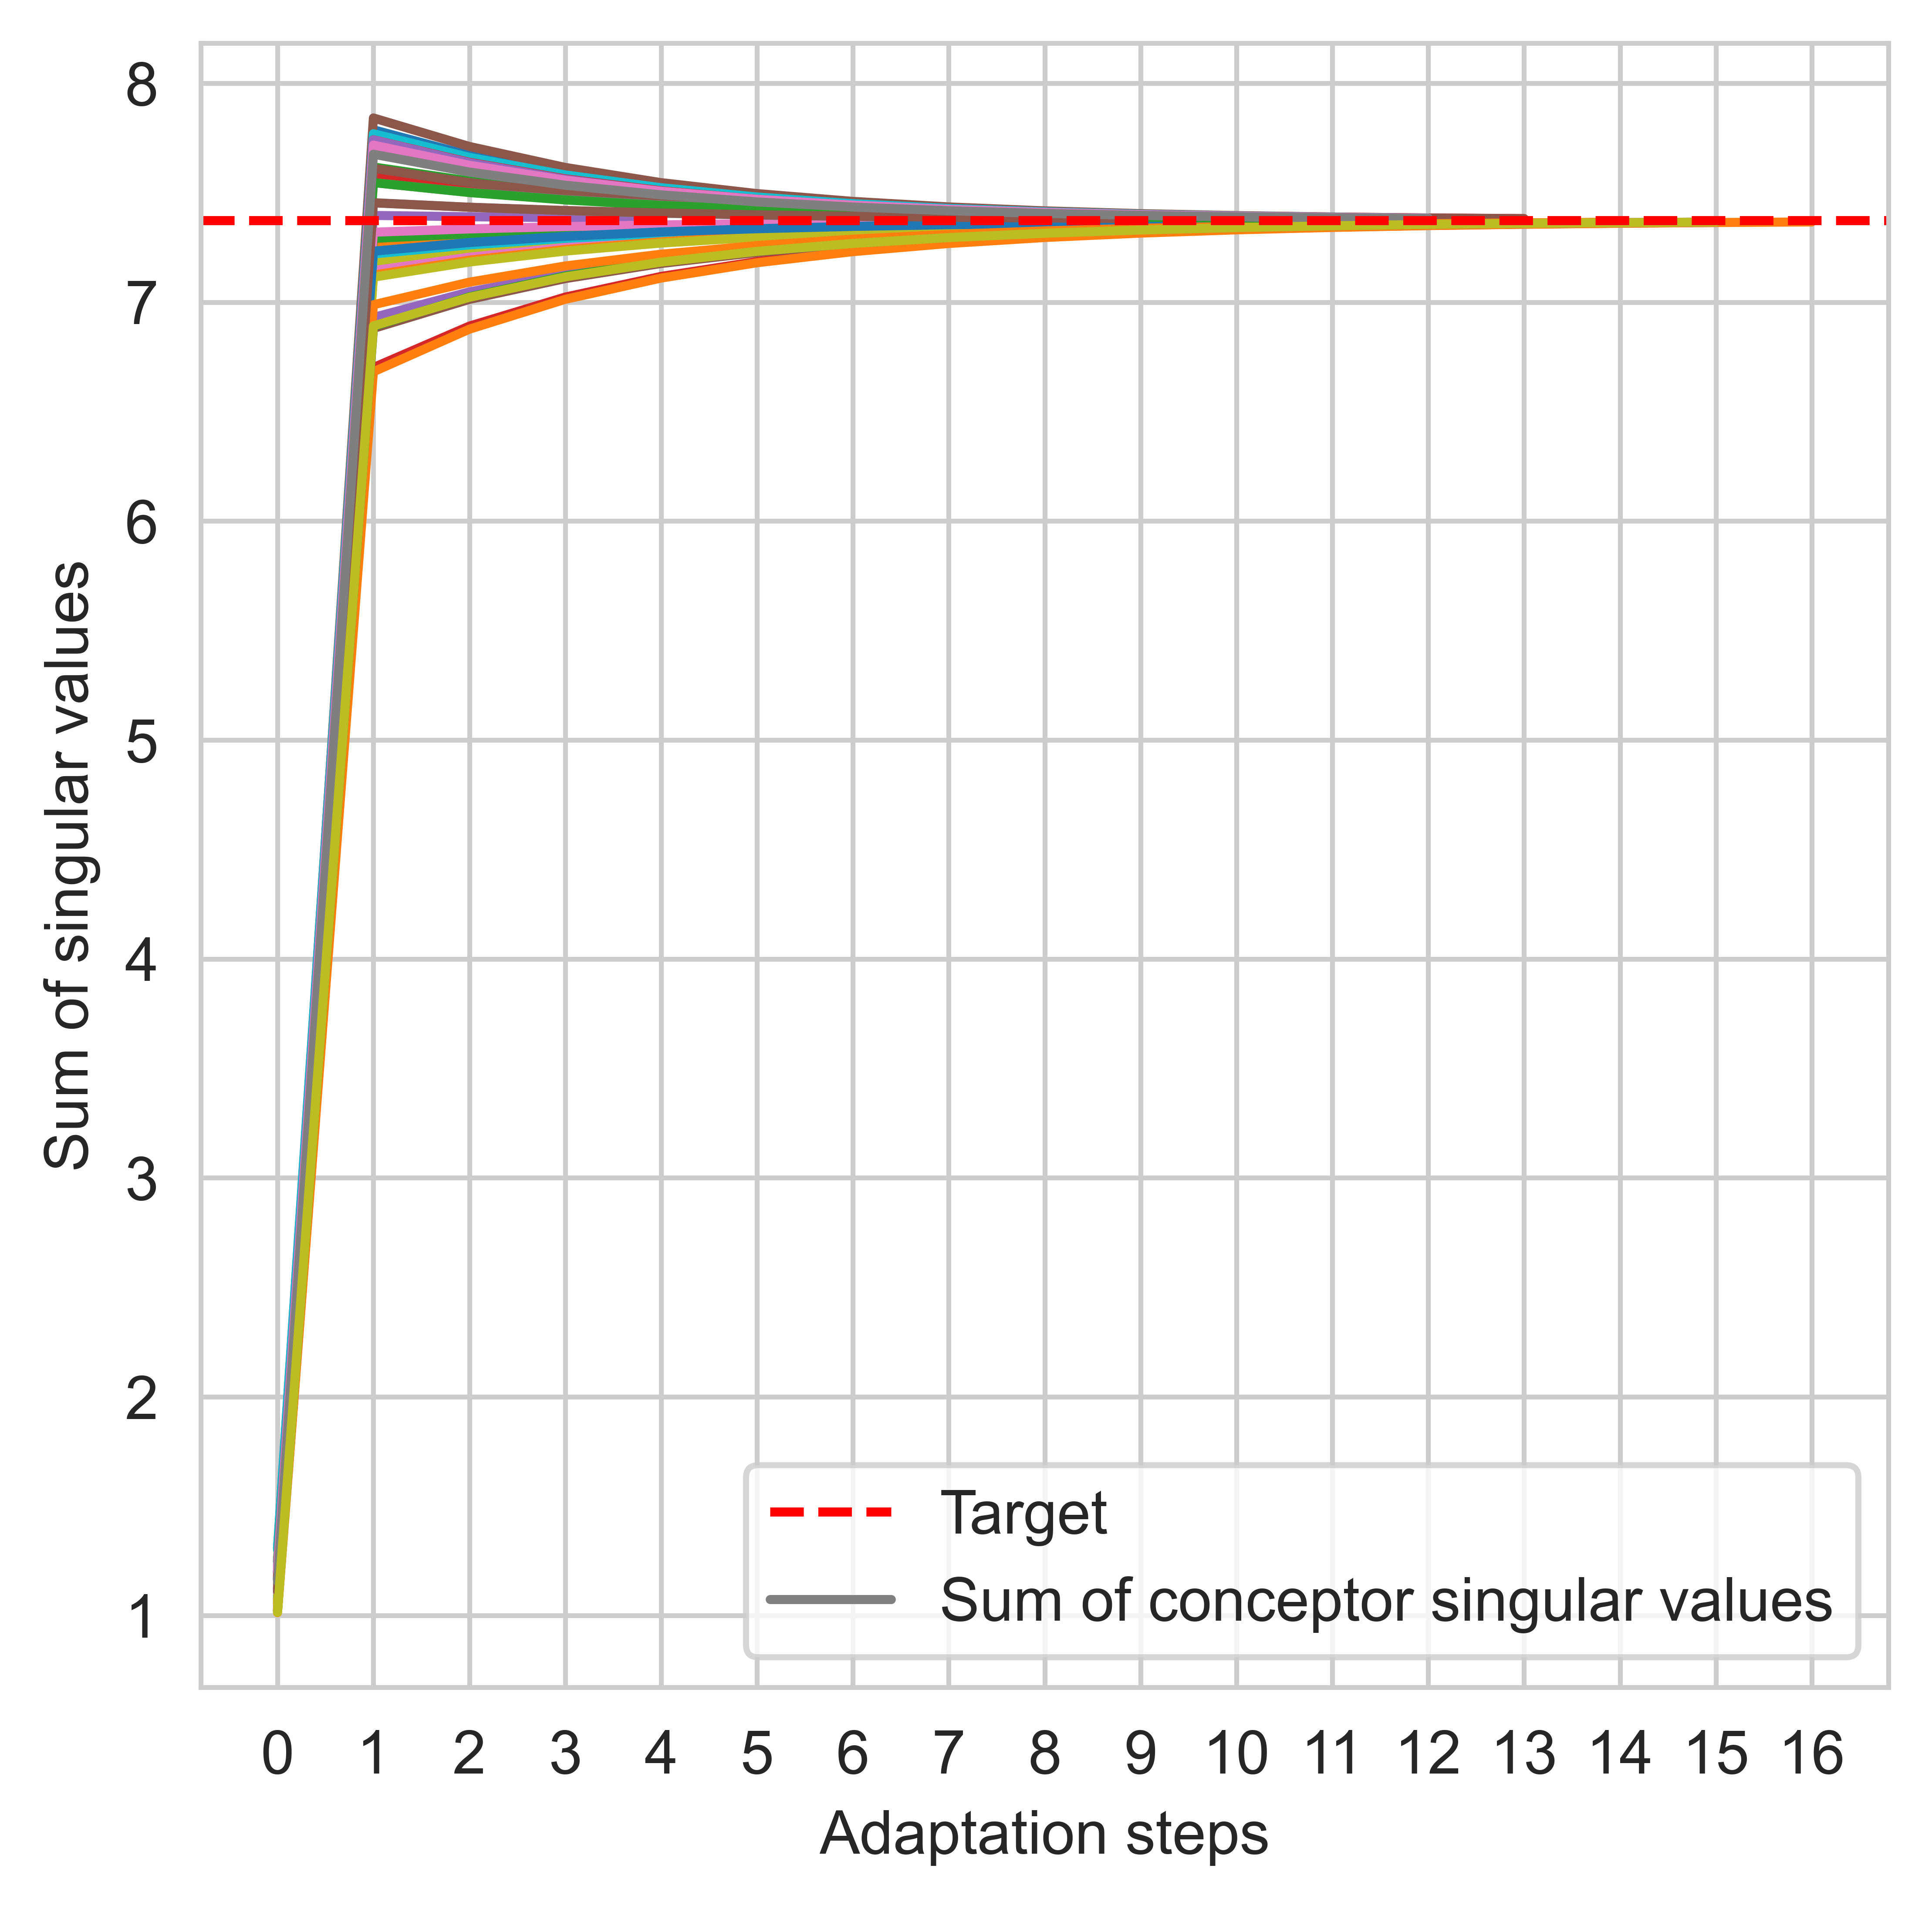

- computing negative conceptors


Classifier(W_in_scale=1.5, b_scale=0.2, spectral_radius=1.5, weights=0.1)

In [13]:
# Method "X"
optx = Classifier(1.5,
    .2,
    1.5,
    .1)

optx.fit(features_train, labels_train, **{
    "n_mels":n_mels,
    "XorZ":'X'
})

# # Method "Z
# optz = Classifier(1.5,
#     .2,
#     1.5,
#     .1)
#
# optz.fit(features_train, labels_train, **{
#     "n_mels":n_mels,
#     "XorZ":"Z"
# })

## Testing
### Feature Collection

In [14]:
print("Testing...")

features_test, labels_test, _ = fc.collectFeaturesInSegments(
    ft='Test',n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=[],dr=dr,sentence=[],
    subsamples=subsamples,path_option=path_option+"_test")

_, features_test, labels_test = filter_data(features_test, labels_test, limit=None)

print(f'Training Accuracy of x : {optx.score(features_train, labels_train)}')
print(f'Test Accuracy of x     : {optx.score(features_test, labels_test)}')

# print(f'Training Accuracy of z : {optz.score(features_train, labels_train)}')
# print(f'Test Accuracy of z     : {optz.score(features_test, labels_test)}')

Testing...
-from output
---- success
Filtered to 64145 samples of shape (10, 13)
Training Accuracy of x : 0.4064151795798509
Test Accuracy of x     : 0.40419362382103047


# Displaying Confusion Matrix

In [ ]:
cm = confusion_matrix(labels_test, opt.predict(features_test), labels=phonemes)

In [ ]:
plt.rcParams['text.usetex'] = False

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

from sklearn.metrics import confusion_matrix


# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, target_names=phonemes,
                      title='Confusion matrix, without normalization')

plt.show()

In [ ]:
#with open('res.txt','x') as file:
#    file.write(opt.score(fv,lv))
#    file.write(opt.best_params_)